In [24]:
#!pip install ssspy

In [2]:
import numpy as np
import scipy.signal as ss
import matplotlib.pyplot as plt
import IPython.display as ipd 
from tqdm.notebook import tqdm

In [3]:
#from ssspy.utils.dataset import download_sample_speech_data

In [4]:
n_sources = 2
max_duration = 10
reverb_duration = 0.36
sisec2010_tag = "dev1_female3"
n_fft, hop_length = 4096, 2048

In [5]:
waveform_src_img, sample_rate = download_sample_speech_data(
    n_sources=n_sources,
    sisec2010_tag=sisec2010_tag,
    max_duration=max_duration,
    reverb_duration=reverb_duration,
    conv=True,
)  # (n_channels, n_sources, n_samples)
waveform_mix = np.sum(waveform_src_img, axis=1)  # (n_channels, n_samples)

In [6]:
for idx, waveform in enumerate(waveform_mix):
    print("Mixture: {}".format(idx + 1))
    display(ipd.Audio(waveform, rate=sample_rate))
    print()

Mixture: 1



Mixture: 2


In [7]:
from ssspy.bss.mnmf import GaussMNMF as GaussMNMFBase

In [8]:
class GaussMNMF(GaussMNMFBase):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.progress_bar = None

    def __call__(self, *args, n_iter: int = 100, **kwargs) -> np.ndarray:
        self.n_iter = n_iter

        return super().__call__(*args, n_iter=n_iter, **kwargs)

    def update_once(self) -> None:
        if self.progress_bar is None:
            self.progress_bar = tqdm(total=self.n_iter)

        super().update_once()

        self.progress_bar.update(1)

In [9]:
#w/ partitioning

mnmf = GaussMNMF(
    n_basis=30,
    n_sources=2,
    partitioning=True,
    rng=np.random.default_rng(42),
)
print(mnmf)

GaussMNMF(n_basis=30, n_sources=2, partitioning=True, normalization=True, record_loss=True, reference_id=0)


In [10]:
_, _, spectrogram_mix = ss.stft(waveform_mix, window="hann", nperseg=n_fft, noverlap=n_fft-hop_length)

In [12]:
spectrogram_est = mnmf(spectrogram_mix, n_iter=200)

In [13]:
_, waveform_est = ss.istft(spectrogram_est, window="hann", nperseg=n_fft, noverlap=n_fft-hop_length)

In [23]:
#for idx, waveform in enumerate(waveform_est):
    #print("Estimated source: {}".format(idx + 1))
    #display(ipd.Audio(waveform, rate=sample_rate))
    #print()

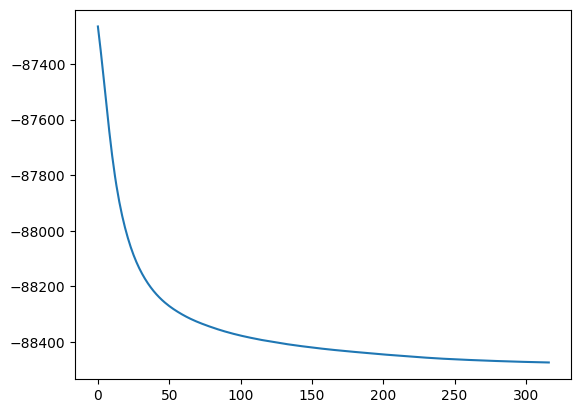

In [15]:
plt.figure()
plt.plot(mnmf.loss[10:])
plt.show()
plt.close()

In [16]:
#w/o partitioning

mnmf = GaussMNMF(
    n_basis=10,
    n_sources=2,
    partitioning=False,
    rng=np.random.default_rng(42),
)
print(mnmf)

GaussMNMF(n_basis=10, n_sources=2, partitioning=False, normalization=True, record_loss=True, reference_id=0)


In [17]:
_, _, spectrogram_mix = ss.stft(waveform_mix, window="hann", nperseg=n_fft, noverlap=n_fft-hop_length)

In [18]:
spectrogram_est = mnmf(spectrogram_mix, n_iter=500)

  0%|          | 0/500 [00:00<?, ?it/s]

In [19]:
_, waveform_est = ss.istft(spectrogram_est, window="hann", nperseg=n_fft, noverlap=n_fft-hop_length)

In [22]:
#for idx, waveform in enumerate(waveform_est):
    #print("Estimated source: {}".format(idx + 1))
    #display(ipd.Audio(waveform, rate=sample_rate))
    #print()

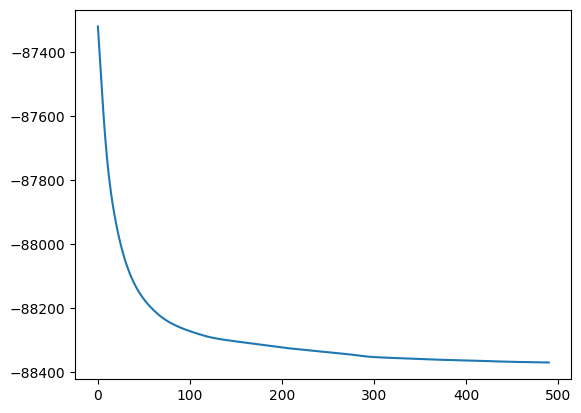

In [21]:
plt.figure()
plt.plot(mnmf.loss[10:])
plt.show()
plt.close()

-----------------------------------------------------------

On our data